In [1]:
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
cis_trans_regulate_sameGene=read.table("./cis_trans_regulate_same_gene.txt",header=T)
head(cis_trans_regulate_sameGene)

,stage,eGene,transVariant,cisVariant,randomSNP,realCor,randomCor
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,0DPA,Ghir_A01G000700,SNP170274,SNP118,SNP1480141,0.9172327,-0.0208758952
2,0DPA,Ghir_A01G000700,SNP170274,SNP172,SNP1486297,-0.3342120,-0.0359792929
3,0DPA,Ghir_A01G000750,SNP170283,SNP222,SNP1347183,0.6828086,0.1488801788
4,0DPA,Ghir_A01G000940,SNP170274,SNP331,SNP1974859,-0.3284709,-0.0323418627
5,0DPA,Ghir_A01G000970,SNP170270,SNP525,SNP1525035,0.8979658,0.0005320345
6,0DPA,Ghir_A01G001190,SNP1930261,SNP604,SNP2015164,0.2440031,0.1260892274


In [8]:
#* 统计存在的SNPs数目
cis_trans_regulate_sameGene %>% count(stage)

stage,n
<fct>,<int>
0DPA,2426
12DPA,3742
16DPA,2080
20DPA,1894
4DPA,2311
8DPA,2482


In [13]:
for(selectedStage in c("0DPA","4DPA","8DPA","12DPA","16DPA","20DPA")){
    filterData=cis_trans_regulate_sameGene%>% filter(stage==selectedStage)
    print(selectedStage)
    print(wilcox.test(abs(filterData$realCor),abs(filterData$randomCor)))
}

[1] "0DPA"

	Wilcoxon rank sum test with continuity correction

data:  abs(filterData$realCor) and abs(filterData$randomCor)
W = 4976909, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

[1] "4DPA"

	Wilcoxon rank sum test with continuity correction

data:  abs(filterData$realCor) and abs(filterData$randomCor)
W = 4627230, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

[1] "8DPA"

	Wilcoxon rank sum test with continuity correction

data:  abs(filterData$realCor) and abs(filterData$randomCor)
W = 5382388, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

[1] "12DPA"

	Wilcoxon rank sum test with continuity correction

data:  abs(filterData$realCor) and abs(filterData$randomCor)
W = 10821658, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

[1] "16DPA"

	Wilcoxon rank sum test with continuity correction

data:  abs(filterData$realCor) and abs(filterData$randomC

In [159]:
plotData <- cis_trans_regulate_sameGene %>% pivot_longer(
    cols = c("realCor", "randomCor"),
    values_to = "cor",
    names_to = "SNPType"
    )
plotData$stage=factor(plotData$stage,levels = c('0DPA','4DPA','8DPA','12DPA','16DPA','20DPA'))    

png 
  2

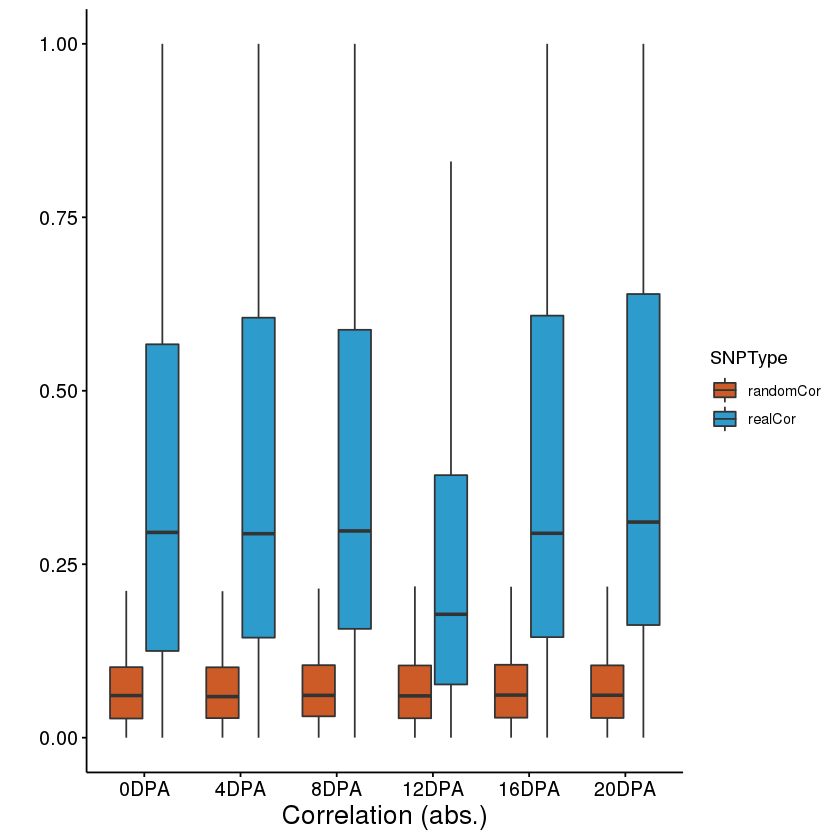

In [162]:
p <- plotData %>% ggplot(aes(x = stage, y = abs(cor))) +
    geom_boxplot(
        aes(fill = SNPType),
        outlier.colour = NA
    ) +
    theme_classic() +
    base_theme +
    xlab("Correlation (abs.)") +
    ylab("") +
    scale_fill_manual(
        values = c("#cc5b28", "#2d9ccc")
    )
pdf("cis_trans_sameGene_cor.pdf")
print(p)
dev.off()
p

### TODO 分析随机挑选SNP在cis-eQTL中的富集情况

In [2]:
library(ggplot2)

In [3]:
#-------------------------------------------------------
#* 分析随机挑选SNP在cis-eQTL中的富集情况
# ? 每次random与真实值进行比较，就获得了odd值的相应分布
#-------------------------------------------------------

plotData <- c()
pvalList <- c()

for (stage in c("0DPA", "4DPA", "8DPA", "12DPA", "16DPA", "20DPA")) {
    randomData <- read.table(paste(
        "./cis_mediation_trans_random/", stage, "_random_result.txt",
        sep = ""
    ), header = T)
    #* 每次随机状态下，随机SNP同时是cis-eQTL SNP的数目
    randomData <- randomData %>%
        mutate(cisGene = ifelse(cisVariant != "-", 1, 0)) %>%
        group_by(randomId) %>%
        count(
            cisGene
        )
    realData <- read.table(paste(stage, "_cis_mediant_transRegulate.txt", sep = ""), header = T)
    realData=realData %>% select(
    c(transVariant,cisVariant)
    ) %>% distinct()
    realData <- realData %>%
        mutate(cisGene = ifelse(cisVariant != "-", 1, 0)) %>%
        count(cisGene)
    for (i in seq(1, 10)) {
        tmpData <- randomData %>% filter(randomId == i)
        tmpData <- data.frame(tmpData)
        odd <- fisher.test(
            matrix(
                c(realData[2, 2], realData[1, 2], tmpData[2, 3], tmpData[1, 3]),
                nrow = 2
            )
        )
        plotData <- c(plotData, odd$estimate)
        pvalList <- c(pvalList, odd$p.value)
    }
}
rawOddRatio=data.frame(
    stage = rep(c("0DPA", "4DPA", "8DPA", "12DPA", "16DPA", "20DPA"), each = 10),
    randomId = rep(seq(1, 10), n = 6),
    oddRatio = plotData,
    pval = pvalList
)
plotData=rawOddRatio %>%
    group_by(stage) %>%
    mutate(oddMin = min(oddRatio),meanOdd = mean(oddRatio),oddMax = max(oddRatio),meanPval=mean(pval))
plotData$stage=factor(plotData$stage,levels = c('0DPA','4DPA','8DPA','12DPA','16DPA','20DPA'))
plotData %>% filter(randomId==1)

stage,randomId,oddRatio,pval,oddMin,meanOdd,oddMax,meanPval
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0DPA,1,1.488081,3.637607e-11,1.329275,1.447498,1.527471,2.152126e-07
4DPA,1,1.378988,9.240415e-08,1.287282,1.372850,1.484050,4.161213e-06
8DPA,1,1.477444,5.444230e-11,1.401607,1.488641,1.562099,1.335002e-09
12DPA,1,1.202474,1.268627e-03,1.052955,1.142617,1.214588,6.088328e-02
16DPA,1,1.570684,5.054794e-13,1.360472,1.550719,1.642747,7.478727e-08
20DPA,1,1.546616,9.804155e-12,1.313364,1.446457,1.554412,1.645200e-06


In [4]:
plotData %>% group_by(stage) %>% summarise(mean(meanPval))

stage,mean(meanPval)
<fct>,<dbl>
0DPA,2.152126e-07
4DPA,4.161213e-06
8DPA,1.335002e-09
12DPA,6.088328e-02
16DPA,7.478727e-08
20DPA,1.645200e-06


png 
  2

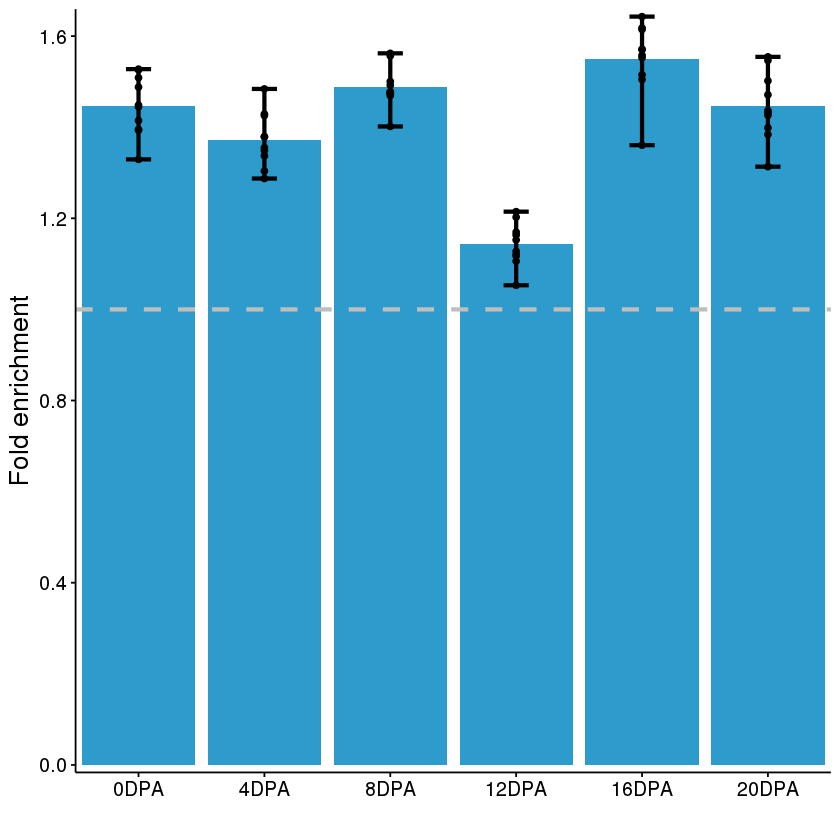

In [9]:
p <- plotData %>%
    filter(randomId == 1) %>%
    ggplot(
        aes(x = stage, y = meanOdd)
    ) +
    geom_bar(stat = "identity", fill = "#2d9ccc") +
    geom_errorbar(
        aes(ymin = oddMin, ymax = oddMax),
        width = 0.2,
        size = 1.2,
    ) +
    geom_point(
        data=plotData,aes(x=stage,y=oddRatio),inherit.aes = FALSE,
        size=1.5,
    )+
    geom_hline(
        yintercept = 1,
        linetype = "dashed", size = 1.2,
        color = "grey"
    ) +
    theme_classic() +
    base_theme +
    scale_x_discrete(
        expand = c(0.1, 0)
    ) +
    scale_y_continuous(
        expand = c(0.01, 0)
    ) +
    ylab("Fold enrichment") +
    xlab("")
pdf("cis_mediate_trans_enrichment.pdf")
print(p)
dev.off()
p